# Ejercicio 2 — Canal digital con ecos

En este ejercicio se analiza un sistema lineal e invariante en el tiempo (SLID) que modela el comportamiento de un **canal digital con ecos**, representado por su respuesta impulsional _hA[n]_.  

El objetivo es estudiar cómo este canal modifica una señal de audio, caracterizar su comportamiento e implementar filtros en **cascada** que compensen parcialmente los ecos, buscando que la respuesta total del sistema se aproxime a una **delta de Kronecker**.

## Preparativos

Se exporta la respuesta impulsional _hA[n]_ desde Octave mediante la función `hcanald`, guardándola en un archivo CSV para su análisis en Python.


## Parte 2: Respuesta Impulsional

Se importa _hA[n]_, se grafica en el dominio del tiempo y se implementa la función `sA(x)` que modela el canal FIR.


### Importación de librerías

Además de las librerías utilizadas en el Ejercicio 1, en este caso se incorporan dos módulos adicionales para el manejo de audio:

- **`scipy.io.wavfile`**: permite leer y escribir archivos de audio en formato WAV, retornando tanto la frecuencia de muestreo (_fs_) como la señal digital _x[n]_ en forma de arreglo NumPy.  
- **`IPython.display.Audio`**: habilita la reproducción de señales de audio directamente en el entorno Jupyter, facilitando la comparación auditiva.


In [56]:
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.io import wavfile
from IPython.display import Audio
from scipy.signal import lfilter

### Importación y visualización de la respuesta impulsional _hA[n]_

Se carga la respuesta impulsional del canal digital desde el archivo `ha.csv`.

La señal _hA[n]_ representa el modelo del canal en tiempo discreto, donde cada impulso indica un eco con su correspondiente retardo y atenuación.  

El gráfico permite observar la ubicación temporal y magnitud de cada componente del canal, evidenciando que la mayor parte de las muestras son nulas salvo en los instantes donde aparecen los ecos.

Además, se identifican las muestras no nulas de la respuesta impulsional con el fin de determinar la posición y amplitud de los ecos.


Se encontraron 3 muestras no nulas de 26460:

hA[0] = 1.0000
hA[8820] = -0.4500
hA[17640] = 0.2025


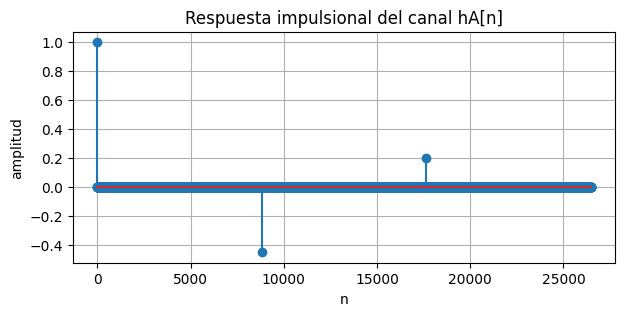

In [63]:
# =================
# 1) Importar hA[n]
# =================
data_ha = np.loadtxt("../data/ha.csv", delimiter=",")
nha = data_ha[:, 0].astype(int)
hA  = data_ha[:, 1].astype(float)

# =================
# Análisis de hA[n]
# =================

# Índices y valores no nulos
nonzero_idx = np.nonzero(hA)[0]
nonzero_vals = hA[nonzero_idx]

print(f"\nSe encontraron {len(nonzero_idx)} muestras no nulas de {len(hA)}:\n")

for i, v in zip(nonzero_idx, nonzero_vals):
    print(f"hA[{nha[i]}] = {v:.4f}")

# ==============
# Graficar hA[n]
# ==============

plt.figure(figsize=(7, 3))
plt.stem(nha, hA)
plt.title("Respuesta impulsional del canal hA[n]")
plt.xlabel("n")
plt.ylabel("amplitud")
plt.grid(True)
plt.show()



### Implementación del sistema _sA_ y verificación de la respuesta impulsional

Se define la función _sA(x)_, que modela el canal digital mediante la ecuación en diferencias:

_y[n] = x[n] − 0.45·x[n−8820] + 0.2025·x[n−17640]_

Esta ecuación representa un sistema **FIR con dos ecos**, donde cada término desplazado corresponde a una réplica retardada y atenuada de la señal original.

Posteriormente, se valida la implementación aplicando una delta de Kronecker como entrada (_x[n] = δ[n]_) y comparando la salida obtenida con la respuesta impulsional teórica _hA[n], garantizando que la función implementa correctamente el modelo del canal.

In [64]:
# y[n] = x[n] - 0.45 x[n-8820] + 0.2025 x[n-17640]
def sA(nx, x):
    x = x.astype(float)
    y = np.zeros_like(x, dtype=float)
    N = len(x)

    # tap 0
    y += x

    # tap en 8820
    if N > 8820:
        y[8820:] += -0.45 * x[:-8820]

    # tap en 17640
    if N > 17640:
        y[17640:] += 0.2025 * x[:-17640]

    return y

# ===========================================
# Verificación de coincidencia hA y Sa{d[n]}
# ===========================================

nd = np.arange(len(hA))
d  = np.zeros_like(nd, dtype=float)
d[0] = 1.0

hA_chk = sA(nd, d)

if np.allclose(hA_chk, hA):
    print("✅ Coincidencia: la función sA reproduce la respuesta impulsional hA[n].")
    print(f"Longitud de la señal: {len(hA)} muestras, componentes no nulas: {np.count_nonzero(hA)}")
else:
    diff = np.max(np.abs(hA_chk - hA))
    print("⚠️  Diferencia detectada entre hA y sA(delta).")


✅ Coincidencia: la función sA reproduce la respuesta impulsional hA[n].
Longitud de la señal: 26460 muestras, componentes no nulas: 3


## Parte 3:  Señal de entrada

   Se carga un archivo de audio (`audio.wav`), se grafica en el dominio del tiempo y se obtiene su TFTD numérica.

### Carga y reproducción de la señal de audio

Se importa el archivo `audio.wav`, obteniendo la frecuencia de muestreo (`fs`) y la señal cruda (`x_raw`).

La señal se **normaliza en [-1, 1]** y se **convierte a mono** (como fue recomendado en la cátedra) promediando los canales.

Se construyen los ejes para graficar y analizar, y se habilita la **reproducción** directa en el notebook para su reproducción.

In [65]:
# =========================================
# Carga y reproducción del audio de entrada
# =========================================

# 1) Importar WAV
fs, x_raw = wavfile.read("../data/audio.wav")   # fs esperado: 48000 Hz
# Normalizar a float en [-1, 1] y pasar a mono si es estéreo
x = x_raw.astype(float)
if x.dtype.kind in ("i", "u"):
    max_abs = np.iinfo(x_raw.dtype).max
    x = x / max_abs
if x.ndim == 2:
    x = x.mean(axis=1)

# Eje discreto y eje en segundos
nx = np.arange(len(x), dtype=int)
t  = nx / fs

# 2) Reproducir dentro del notebook
Audio(x, rate=fs)




## Parte 3: Salida del sistema

Se filtra la señal de entrada a través del canal para obtener _y[n]_, observando los efectos de los ecos y analizando los cambios espectrales.




### Aplicación del canal al audio de entrada

Se aplica la función _sA_ al vector de muestras _x[n]_ para obtener la salida _y[n]_, que representa cómo el canal afecta a la señal original.

In [68]:
# canal sA aplicado a x[n]
y = sA(nx, x)
from IPython.display import Audio
Audio(y, rate=fs)

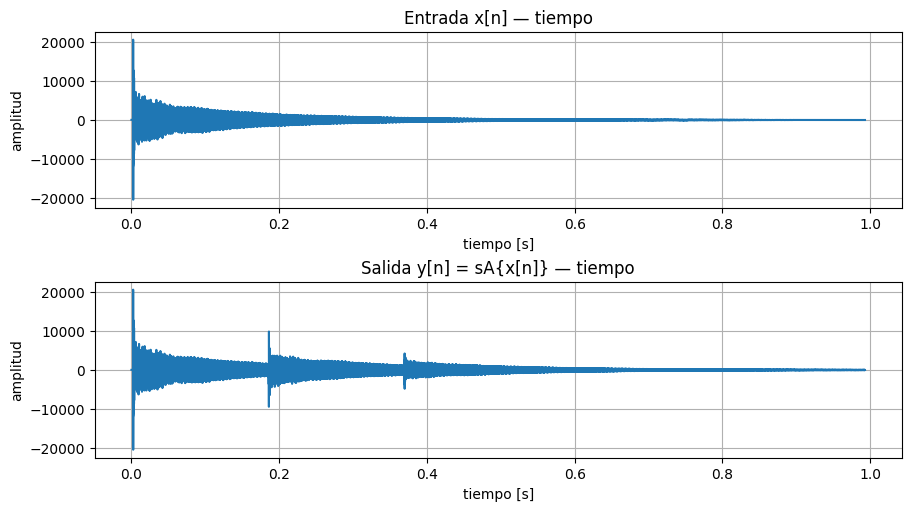

In [69]:
# ============================
# Gráficos en dominio del tiempo (x vs y)
# ============================
fig, axes = plt.subplots(2, 1, figsize=(9, 5), constrained_layout=True)

axes[0].plot(t, x)
axes[0].set_title("Entrada x[n] — tiempo")
axes[0].set_xlabel("tiempo [s]")
axes[0].set_ylabel("amplitud")
axes[0].grid(True)

axes[1].plot(t, y)
axes[1].set_title("Salida y[n] = sA{x[n]} — tiempo")
axes[1].set_xlabel("tiempo [s]")
axes[1].set_ylabel("amplitud")
axes[1].grid(True)

plt.show()


La señal de salida _y[n]_ conserva la forma general del audio original, pero con repeticiones retardadas que corresponden a los ecos introducidos por el canal. Auditivamente se perciben como ecos del sonido principal.

## Parte 4: Filtros compensadores en cascada

Se diseñan filtros FIR con dos y tres ramas de retardo para cancelar los ecos del canal.

Se evalúan sus ecuaciones en diferencias, se calculan las respuestas impulsionales en cascada y se comparan con el canal original, verificando auditivamente el resultado obtenido.

### Filtros compensadores en cascada

Se definen dos funciones que modelan **filtros FIR correctores** diseñados para reducir los ecos introducidos por el canal:

- **`fir_cascade_2branch`**: implementa un filtro con dos ramas de retardo. Cada rama agrega una copia retardada de la señal de entrada, escalada por un factor (`beta1`, `beta2`).  
  Su ecuación general es:  
  _y[n] = x[n] + β₁·x[n−n₁] + β₂·x[n−n₂]_  

- **`fir_cascade_3branch`**: extiende el modelo anterior agregando una tercera rama (`β₃`, `n₃`) para mejorar la cancelación de los ecos residuales.  
  Por defecto, el retardo de esta tercera rama se calcula como _n₃ = n₁ + n₂_, lo que atenúa los términos cruzados producidos al combinar los ecos del canal y del filtro.

En ambos casos, la idea es aplicar estos filtros **después del canal**, reduciendo los ecos mediante la suma de versiones retardadas y ponderadas del audio.

In [50]:
import numpy as np

# Canal estimado (para referencia teórica):
# hA[n] = δ[n] − 0.45·δ[n−8820] + 0.2025·δ[n−17640]
# n1 = 8820, n2 = 17640 (= 2*n1)

def fir_cascade_2branch(nx, x, beta1=0.45, n1=8820, beta2=0.0, n2=17640):
    """
    Filtro FIR compensador de 2 ramas:
      y[n] = x[n] + beta1·x[n−n1] + beta2·x[n−n2]
    Retarda con relleno cero (CI nulas). Mantiene la longitud de x.
    """
    x = x.astype(float)
    y = np.zeros_like(x, dtype=float)
    N = len(x)

    # rama 0
    y += x
    # rama n1
    if N > n1:
        y[n1:] += beta1 * x[:-n1]
    # rama n2
    if N > n2:
        y[n2:] += beta2 * x[:-n2]

    return y

def fir_cascade_3branch(nx, x, beta1=0.45, n1=8820, beta2=0.0, n2=17640,
                        beta3=-0.091125, n3=None):
    """
    Filtro FIR compensador de 3 ramas:
      y[n] = x[n] + beta1·x[n−n1] + beta2·x[n−n2] + beta3·x[n−n3]
    Por defecto n3 = n1 + n2, para cancelar el término cruzado dominante.
    """
    if n3 is None:
        n3 = n1 + n2

    x = x.astype(float)
    y = np.zeros_like(x, dtype=float)
    N = len(x)

    # rama 0
    y += x
    # rama n1
    if N > n1:
        y[n1:] += beta1 * x[:-n1]
    # rama n2
    if N > n2:
        y[n2:] += beta2 * x[:-n2]
    # rama n3
    if N > n3:
        y[n3:] += beta3 * x[:-n3]

    return y


### Respuestas impulsionales de la cascada

Se analiza cómo se modifica la respuesta del canal al aplicar los filtros compensadores en cascada.  
Primero, se utiliza una delta de Kronecker como entrada para obtener la **respuesta impulsional total** de cada combinación:

- _h₁[n]_: canal solo.  
- _h₂[n]_: canal seguido del filtro de 2 ramas.  
- _h₃[n]_: canal seguido del filtro de 3 ramas.  

El gráfico compara las tres respuestas en el dominio temporal.

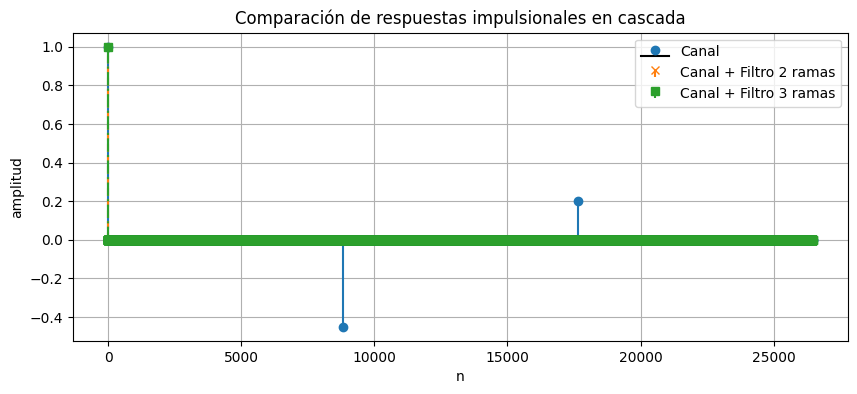

In [71]:
# ============================
# Respuestas impulsionales de la cascada
# ============================

# Delta de prueba
nd = np.arange(0, len(hA))
d  = np.zeros_like(nd, dtype=float)
d[0] = 1.0

# Canal solo
h1 = sA(nd, d)

# Canal + filtro 2 ramas
y2_delta = fir_cascade_2branch(nd, h1)
h2 = y2_delta  # respuesta impulsional total (canal + filtro 2 ramas)

# Canal + filtro 3 ramas
y3_delta = fir_cascade_3branch(nd, h1)
h3 = y3_delta  # respuesta impulsional total (canal + filtro 3 ramas)

# ============================
# Gráficos comparativos
# ============================
plt.figure(figsize=(10, 4))
plt.stem(nd, h1, linefmt='C0-', markerfmt='o', basefmt='k', label='Canal')
plt.stem(nd, h2, linefmt='C1--', markerfmt='x', basefmt=' ', label='Canal + Filtro 2 ramas')
plt.stem(nd, h3, linefmt='C2-.', markerfmt='s', basefmt=' ', label='Canal + Filtro 3 ramas')

plt.title("Comparación de respuestas impulsionales en cascada")
plt.xlabel("n")
plt.ylabel("amplitud")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Se observa que los filtros reducenla amplitud de los ecos, lo que indica una mejor aproximación a una delta

## Salidas filtradas y comparación

Finalmente se reproducen la señal original, la salida del canal, y las salidas con los filtros aplicados

In [72]:
# ============================
# Reproducción (escuchar)
# ============================
from IPython.display import Audio

print("Entrada original x")
display(Audio(x, rate=fs))

print("Salida canal (y = sA{x})")
display(Audio(y, rate=fs))

print("Salida compensada (canal + filtro 2 ramas)")
display(Audio(y2, rate=fs))

print("Salida compensada (canal + filtro 3 ramas)")
display(Audio(y3, rate=fs))


Entrada original x


Salida canal (y = sA{x})


Salida compensada (canal + filtro 2 ramas)


Salida compensada (canal + filtro 3 ramas)


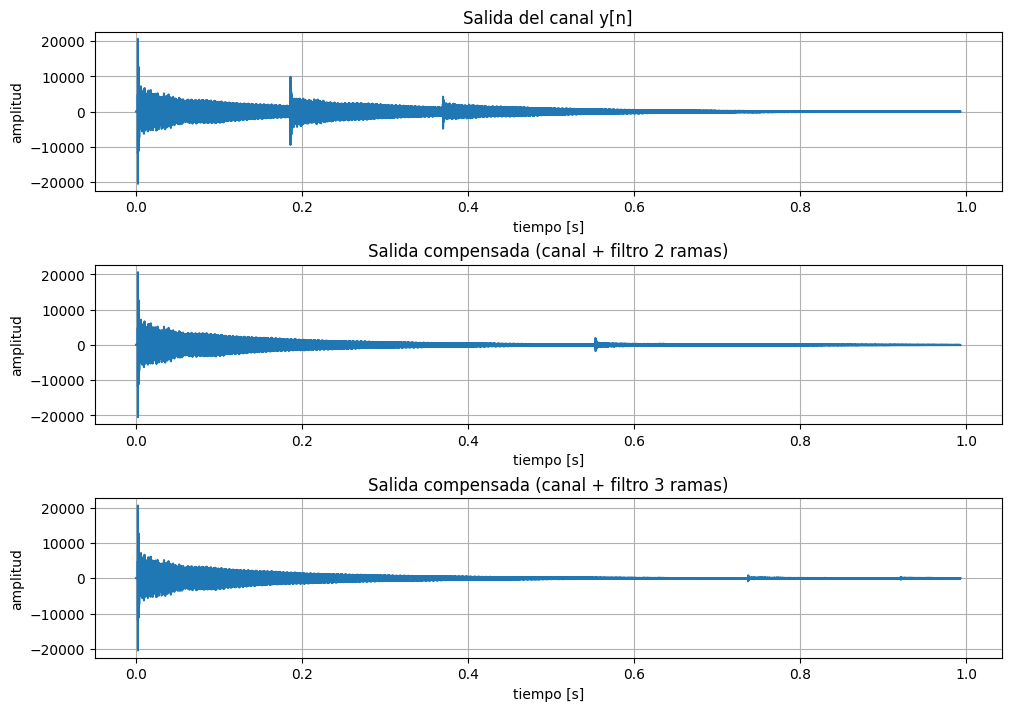

In [73]:
# ============================
# Gráficos en tiempo (tres señales)
# ============================
fig, axes = plt.subplots(3, 1, figsize=(10, 7), constrained_layout=True)

axes[0].plot(t, y)
axes[0].set_title("Salida del canal y[n]")
axes[0].set_xlabel("tiempo [s]")
axes[0].set_ylabel("amplitud")
axes[0].grid(True)

axes[1].plot(t, y2)
axes[1].set_title("Salida compensada (canal + filtro 2 ramas)")
axes[1].set_xlabel("tiempo [s]")
axes[1].set_ylabel("amplitud")
axes[1].grid(True)

axes[2].plot(t, y3)
axes[2].set_title("Salida compensada (canal + filtro 3 ramas)")
axes[2].set_xlabel("tiempo [s]")
axes[2].set_ylabel("amplitud")
axes[2].grid(True)

plt.show()


### Comparación auditiva de las salidas filtradas

Al reproducir las señales resultantes, se comprueba que los filtros en cascada logran una corrección efectiva del canal. 

El audio filtrado con los **filtros de 2 y 3 ramas** presentan una notable reducción de los ecos secundarios.

En los gráficos pueden observarse cómo las amplitudes de los ecos se atenúan progresivamente.

El resultado auditivo confirma que ambos filtros compensadores reducen de manera significativa los ecos introducidos por el canal.